In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../scripts')

import stft_zoom, display, detect_musical_regions
from util import *
import mappings
import pickle
import PIL
import IPython.display
from classes import SingleResSpectrogram, MultiResSpectrogram
from aug_density_map import *
from mappings import *
import detect_musical_regions
from classes import MultiResSpectrogram, SingleResSpectrogram

/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


### Representação da solução multinivel

In [64]:
y, sr = librosa.load('../../midi-experiment/notebooks/testee.wav', sr=44100)

In [65]:
spec = np.abs(librosa.stft(y, n_fft=512, hop_length=512))

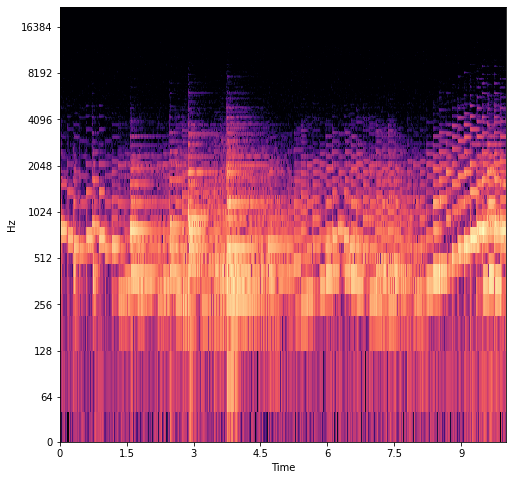

In [66]:
plt.figure(figsize=[8,8])
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), sr=44100,  hop_length=512, y_axis='log', x_axis='time')

In [67]:
time_span = [0,len(y)/sr]
_, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 
shannon, renyi = mappings.extract_features(spec, [800,800], n_fft=512, hop_size=512, sr=sr, fft_freqs=y_axis)

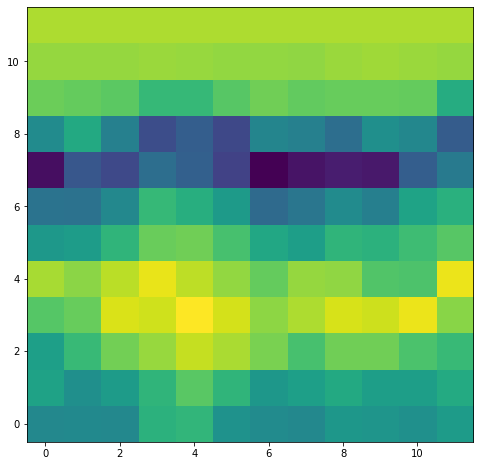

In [69]:
plt.figure(figsize=[8,8])
plt.imshow(shannon * renyi, aspect='auto', origin='lower')
# plt.colorbar()

Tentativa 1: usando o algoritmo automático

In [39]:
def our_solution(y, res, kernel, model, pct, sr=44100, n_fft=512, hop_size=128):
    spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))
    time_span = [0,len(y)/sr]
    x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 
    base_spec = SingleResSpectrogram(spec, x_axis, y_axis)
    multires_spec = MultiResSpectrogram(base_spec)
    indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, kernel=kernel, mode='pct', pct_or_threshold=pct, n_fft=n_fft, hop_size=hop_size)
    to_be_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)

    stft_zoom.set_signal_bank(y,kernel)

    for subregion in to_be_refined:
        freq_range = subregion[0]
        time_range = subregion[1]
        spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=res)
        refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis)
        multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1)
        
    return multires_spec

def our_solution_multilevel(y, res_list, kernel_list, model, pct_list, sr=44100, n_fft=512, hop_size=128):
    o_n_fft = n_fft
    o_hop_size = hop_size
    spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))
    time_span = [0,len(y)/sr]
    x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 
    base_spec = SingleResSpectrogram(spec, x_axis, y_axis)
    multires_spec = MultiResSpectrogram(base_spec)
    
    kernel = kernel_list[0]
    indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, kernel=kernel, mode='pct', pct_or_threshold=pct_list[0], n_fft=n_fft, hop_size=hop_size)
    to_be_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)

    stft_zoom.set_signal_bank(y,kernel)
    
#     print(kernel, len(to_be_refined))
    for subregion in to_be_refined:
        freq_range = subregion[0]
        time_range = subregion[1]
        spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=res_list[0])
        refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis, n_fft=window_size, hop_size=hop_size, sr=new_sr)
        multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1)
        
    i = 1
    for kernel in kernel_list[1:]:
        i += 1
#         print(res_list[i-1])
        if i == 2:
            spec_list = multires_spec.first_zoom
        elif i == 3:
            spec_list = multires_spec.second_zoom
        elif i == 4:
            spec_list = multires_spec.third_zoom

        to_be_further_refined = []
        for spec_zoom in spec_list:
            spec        = np.array(spec_zoom.spec, dtype=float)
            x_axis      = spec_zoom.x_axis
            y_axis      = spec_zoom.y_axis
            sr          = spec_zoom.sr
            window_size = spec_zoom.n_fft
            hop_size    = spec_zoom.hop_size
            
            if len(y_axis) == 1 or len(x_axis) == 1:
                continue
            
            indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, mode='pct', pct_or_threshold=pct_list[i-1], kernel=kernel, n_fft=window_size, hop_size=hop_size, sr=sr, y_axis=y_axis)
            to_be_further_refined = to_be_further_refined + detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, sr=sr, hop_size=hop_size)

        sr = 44100
        hop_size = o_hop_size
        n_fft = o_n_fft
#         print(kernel, len(to_be_further_refined))
        for subregion in to_be_further_refined:
            freq_range = subregion[0]
            time_range = subregion[1]
            spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom_nobank(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=res_list[i-1])
            refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis, n_fft=window_size, hop_size=hop_size, sr=new_sr)
            multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=i, normalize=False)
    return multires_spec

In [40]:
res    = 2
kernel = [800,800]
model  = model_800 = pickle.load(open('./renyi_shannon_prollharm_800.sav', 'rb'))
pct    = 1
n_fft  = 512
hop_size = n_fft

spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))
time_span = [0,len(y)/sr]
x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 
base_spec = SingleResSpectrogram(spec, x_axis, y_axis)
multires_spec = MultiResSpectrogram(base_spec)
indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, kernel=kernel, mode='pct', pct_or_threshold=pct, n_fft=n_fft, hop_size=hop_size)
to_be_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)

In [41]:
to_be_refined

[([344.53125, 602.9296875], [3.205574912891986, 4.006968641114983])]

In [42]:
for subregion in to_be_refined:
    freq_range = subregion[0]
    time_range = subregion[1]
    spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom_nobank(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=res)
    refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis, n_fft=window_size, hop_size=hop_size, sr=new_sr)
    multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1)

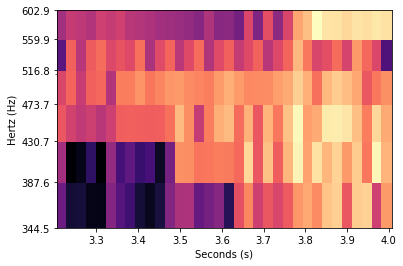

In [43]:
display.specshow(librosa.amplitude_to_db(spec_zoom, ref=np.max), x_axis, y_axis, y_axis='log', x_axis='time')

In [44]:
spec_zoom   = refined_subspec
spec        = np.array(spec_zoom.spec, dtype=float)
x_axis      = spec_zoom.x_axis
y_axis      = spec_zoom.y_axis
sr          = spec_zoom.sr
window_size = spec_zoom.n_fft
hop_size    = spec_zoom.hop_size

indices, original_shape = detect_musical_regions.detect_musical_regions(model_800, spec, mode='pct', pct_or_threshold=50, kernel=[400,400], n_fft=window_size, hop_size=hop_size, sr=sr, y_axis=y_axis)
to_be_further_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, [400,400], sr=sr, hop_size=hop_size)

In [45]:
shannon, renyi = mappings.extract_features(spec, [400,400], n_fft=window_size, hop_size=hop_size, sr=sr, fft_freqs=y_axis)

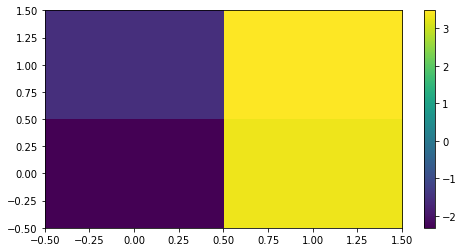

In [46]:
plt.figure(figsize=[8,4])
plt.imshow(shannon * renyi, aspect='auto', origin='lower')
plt.colorbar()

In [47]:
indices

array([3, 1])

In [48]:
to_be_further_refined

[([473.73046875, 602.9296875], [3.6062717770034842, 4.006968641114983]),
 ([344.53125, 473.73046875], [3.6062717770034842, 4.006968641114983])]

In [49]:
sr = 44100
hop_size = 512
n_fft = 512

for subregion in to_be_further_refined[:1]:
    freq_range = subregion[0]
    time_range = subregion[1]
    spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom_nobank(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=4)
    refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis, n_fft=window_size, hop_size=hop_size, sr=new_sr)
    multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1, normalize=False)

In [50]:
y_axis

array([484.42012392, 506.14426185, 527.86839978, 549.59253772,
       571.31667565, 593.04081358, 614.76495151])

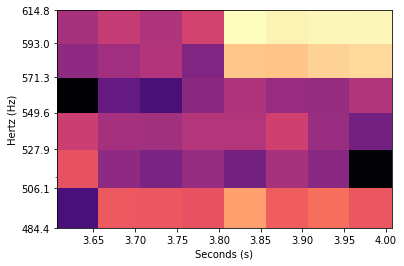

In [51]:
display.specshow(librosa.amplitude_to_db(spec_zoom, ref=np.max), x_axis, y_axis, y_axis='log', x_axis='time')

In [52]:
spec_zoom   = refined_subspec
spec        = np.array(spec_zoom.spec, dtype=float)
x_axis      = spec_zoom.x_axis
y_axis      = spec_zoom.y_axis
sr          = spec_zoom.sr
window_size = spec_zoom.n_fft
hop_size    = spec_zoom.hop_size

indices, original_shape = detect_musical_regions.detect_musical_regions(model_800, spec, mode='pct', pct_or_threshold=50, kernel=[200,200], n_fft=window_size, hop_size=hop_size, sr=sr, y_axis=y_axis)
to_be_further_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, [200,200], sr=sr, hop_size=hop_size)

In [54]:
shannon, renyi = mappings.extract_features(spec, [200,200], n_fft=window_size, hop_size=hop_size, sr=sr, fft_freqs=y_axis)

In [56]:
original_shape

(2, 2)

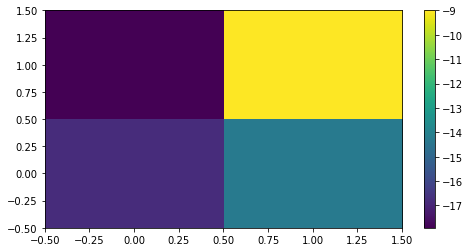

In [55]:
plt.figure(figsize=[8,4])
plt.imshow(shannon * renyi, aspect='auto', origin='lower')
plt.colorbar()

In [53]:
to_be_further_refined

[([549.5925377155172, 614.7649515086207],
  [3.8066202090592336, 4.006968641114983]),
 ([484.4201239224138, 549.5925377155172],
  [3.8066202090592336, 4.006968641114983])]

In [57]:
sr = 44100
hop_size = 512
n_fft = 512

for subregion in to_be_further_refined[:1]:
    freq_range = subregion[0]
    time_range = subregion[1]
    spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom_nobank(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=8)
    refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis, n_fft=window_size, hop_size=hop_size, sr=new_sr)
    multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1, normalize=False)

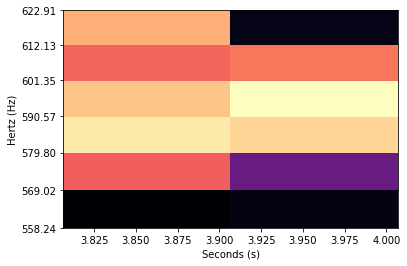

In [58]:
display.specshow(librosa.amplitude_to_db(spec_zoom, ref=np.max), x_axis, y_axis, y_axis='log', x_axis='time')

In [59]:
spec_zoom   = refined_subspec
spec        = np.array(spec_zoom.spec, dtype=float)
x_axis      = spec_zoom.x_axis
y_axis      = spec_zoom.y_axis
sr          = spec_zoom.sr
window_size = spec_zoom.n_fft
hop_size    = spec_zoom.hop_size

In [62]:
shannon, renyi = mappings.extract_features(spec, [100,100], n_fft=window_size, hop_size=hop_size, sr=sr, fft_freqs=y_axis)

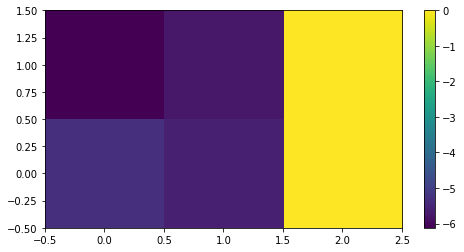

In [63]:
plt.figure(figsize=[8,4])
plt.imshow(shannon * renyi, aspect='auto', origin='lower')
plt.colorbar()